# Project 2 (M9)
# Clustering + SVM: Can We Predict Purchases from Web Sites?

- Author: Ruoyu Chen
- Repository: https://github.com/jc000222/Data_Science_DAV6150/tree/main/M9

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from scipy.cluster import hierarchy
from scipy.stats import boxcox

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

# 1 Introduction
One of the particular interests to most online retailers is whether or not a site visitor ends up executing a purchase while engaged with the web site. Web sites are capable of capturing a wide variety of metrics any time someone accesses one of their web pages, including the recording of the ID of the specific web page visited, the ID's of any items the user either hovered over or clicked on, the elapsed time spent by the user on the page, etc. Online retailers often use such data to try to determine whether or not a given site visitor will actually make a purchase.  

The objective for this project is to use clustering algorithms to create groupings of similar data observations within the provided data set, apply labels to the data observations assigned to those groupings, and then, after completing the necessary EDA and data prep work, construct an SVM model to predict the most likely categorization of any previously unseen data items. After constructing and evaluating your models, you will identify your preferred model and apply it to a testing data set to assess its performance. 

### 1.1 Approach:
- [Introduction](#1-introduction): Import the data set and introduce data variables.
- [Pre-Clustering EDA](#2-Pre-Clustering-eda): Explore the raw dataset and do analysis based on domain knowledge.
- [Pre-Clustering Data Preparation](#3-Pre-Clustering-data-preparation): Describe the data integrity and usability, perform data cleaning, imputation and transformation.  
- [Cluster Modeling](#4-Cluster-Modeling): Perform hierarchical and K-means clustering, interpret outputs.
- [Post-Clustering EDA](#5-Post-Clustering-EDA): Explore cluster groupings generated by K-means algorithm.
- [Clustering Output vs. Actual Labels](#6-Clustering-Output-vs-Actual-Labels): Compare clustering output to actual labels.
- [SVM Modeling](#7-SVM-Modeling): Perform SVM modeling with feature selection methods and kernel functions.
- [Select Models](#8-Select-Models): Explain model selection criteria, identify preferred model, apply to testing data set, and discuss results.
- [Clustering + SVM Output vs. Actual Labels](#9-Clustering-SVM-Output-vs-Actual-Labels): Compare clustering and SVM output to actual labels.


### 1.2 Data Introduction
This project will be working with a data set comprised of a variety of such web site metrics. The dataset consists of feature vectors belonging to 12,330 sessions. The dataset was formed so that each session would belong to a different user in a 1-year period to avoid any tendency to a specific campaign, special day, user profile, or period. 
Read the data from the github repository. The dataframe is shown below.

In [2]:
webdata_raw = pd.read_csv("https://raw.githubusercontent.com/jc000222/Data_Science_DAV6150/main/M9/Project2_Data.csv")
display(webdata_raw.shape)
webdata_raw.head()

(12330, 17)

Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               4                     37.5              2   
3               4                    115.7              0   
4               1                     60.0              1   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               8               222.000000   
1                     0.0              14              1037.500000   
2                    82.0               4                96.625000   
3                     0.0              16               655.383333   
4                    15.0              26               670.166667   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0     0.000000   0.028571   53.474571         0.0   May                 1   
1     0.014286   0.047619    0.000000         0.0   Mar                 2   
2     0.000000   0.017500    0.000000         0.0   Nov                 2   
3     0.000000   0.012037    0.000000         0.0   Nov                 1   
4     0.000000   0.003846    0.000000         0.0   May                 2   

   Browser  Region  TrafficType        VisitorType  Weekend  
0        1       1            2        New_Visitor     True  
1        2       4            2  Returning_Visitor    False  
2        2       9            2        New_Visitor    False  
3        1       2            3  Returning_Visitor    False  
4        2       3            4  Returning_Visitor    False

# 2 Pre-Clustering EDA
In this section, we will explore the raw dataset and analyze the missing and invalid values, make histograms and other graphs to determine how to clean the data to improve its usability.  
Before starting, we define the functions to be used for EDA.

In [3]:
sns.set(style="whitegrid")
def hist(df,attributes,title = None):
    
    if len(attributes) == 1:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
        sns.histplot(data=df[attributes[0]], ax=axes)
        axes.set_xlabel(attributes[0])
        axes.set_ylabel('')
    else:
        fig, axes = plt.subplots(nrows=1, ncols=len(attributes), figsize=(len(attributes)*4, 4))
        for i in range(len(attributes)):
            sns.histplot(ax=axes[i], data=df[attributes[i]])
            axes[i].set_xlabel(attributes[i])
            axes[i].set_ylabel('')
    if title:
        plt.suptitle(title, fontsize=16)
    plt.show()
def box(df,attributes,title = None):
    if len(attributes) == 1:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
        sns.boxplot(data=df[attributes[0]], ax=axes)
        axes.set_xlabel(attributes[0])
        axes.set_ylabel('')
    else:
        fig, axes = plt.subplots(nrows=1, ncols=len(attributes), figsize=(len(attributes)*4, 4))
        for i in range(len(attributes)):
            sns.boxplot(ax=axes[i], data=df[attributes[i]])
            axes[i].set_xlabel(attributes[i])
            axes[i].set_ylabel('')
    if title:
        plt.suptitle(title, fontsize=16)
    plt.show()
def bar(df, attributes):
    if len(attributes) == 1:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
        sns.countplot(x=df[attributes[0]], ax=axes)
        axes.set_xlabel(attributes[0])
        axes.set_ylabel('')
        
        # Add numbers on each bar
        for p in axes.patches:
            axes.annotate(format(p.get_height(), '.0f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha='center', va='center', 
                          xytext=(0, 5), 
                          textcoords='offset points',
                          fontsize=8)
            
    else:
        fig, axes = plt.subplots(nrows=1, ncols=len(attributes), figsize=(len(attributes)*4, 4))
        for i in range(len(attributes)):
            sns.countplot(ax=axes[i], x=df[attributes[i]])
            axes[i].set_xlabel(attributes[i])
            axes[i].set_ylabel('')
            
            # Add numbers on each bar
            for p in axes[i].patches:
                axes[i].annotate(format(p.get_height(), '.0f'), 
                                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                                 ha='center', va='center', 
                                 xytext=(0, 5), 
                                 textcoords='offset points',
                                 fontsize=8) 

    plt.show()
    
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

def bar_sum(df, title):
    num_cols = len(df.columns)
    num_rows = (num_cols - 1) // 3 + 1
    
    colors = sns.color_palette("Set1", 2)
    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(12, num_rows * 3)) 
    for i, column in enumerate(df.columns):
        row_index = i // 3 
        col_index = i % 3 
        sns.barplot(x=df.index, y=column, hue='Cluster', data=df, palette=colors, ax=axes[row_index, col_index], legend=False)
        axes[row_index, col_index].set_xticklabels([])
        axes[row_index, col_index].set_xlabel(f'{column}')
        axes[row_index, col_index].set_ylabel('')
    
    # Remove empty subplots
    for ax in axes.flatten()[num_cols:]:
        ax.remove()
    
    # Create a common legend
    legend_labels = {0: 'Cluster 0', 1: 'Cluster 1'}
    legend_handles = [plt.Rectangle((0,0),1,1, color=colors[i], label=legend_labels[i]) for i in range(2)]
    fig.legend(handles=legend_handles, loc='upper left', ncol=2)
    
    plt.suptitle(f'{title}: {column} Grouped by Cluster')
    plt.tight_layout()
    plt.show()


### Numerical Variable

| Feature                    | Description                                                                                   | Distribution |
|----------------------------|-----------------------------------------------------------------------------------------------|--------------|
| Administrative             | Number of administrative pages visited                                                        | Right-Skewed |
| Administrative Duration    | Total time spent on administrative pages                                                      | Right-Skewed |
| Informational              | Number of informational pages visited                                                         | Right-Skewed |
| Informational Duration     | Total time spent on informational pages                                                       | Right-Skewed |
| Product Related            | Number of product-related pages visited                                                       | Right-Skewed |
| Product Related Duration   | Total time spent on product-related pages                                                     | Right-Skewed |
| Bounce Rate                | Percentage of visitors who enter the site from that page and then leave without triggering any other requests to the analytics server during that session | Right-Skewed |
| Exit Rate                  | Percentage of visitors who were the last in the session                                       | Right-Skewed |
| Page Value                 | Average value for a web page that a user visited before completing an e-commerce transaction  | Right-Skewed |
| Special Day                | Indicates the closeness of the site visiting time to a specific special day                   | Right-Skewed |

The histogram below shows that the numerical variables all have a right-skewed distribution, with variable _'Administrative_Duration','Informational_Duration', 'ProductRelated_Duration'_ have highly skewed values. And _'BounceRates', 'ExitRates','SpecialDay'_ has a large amount of value around right extreme.

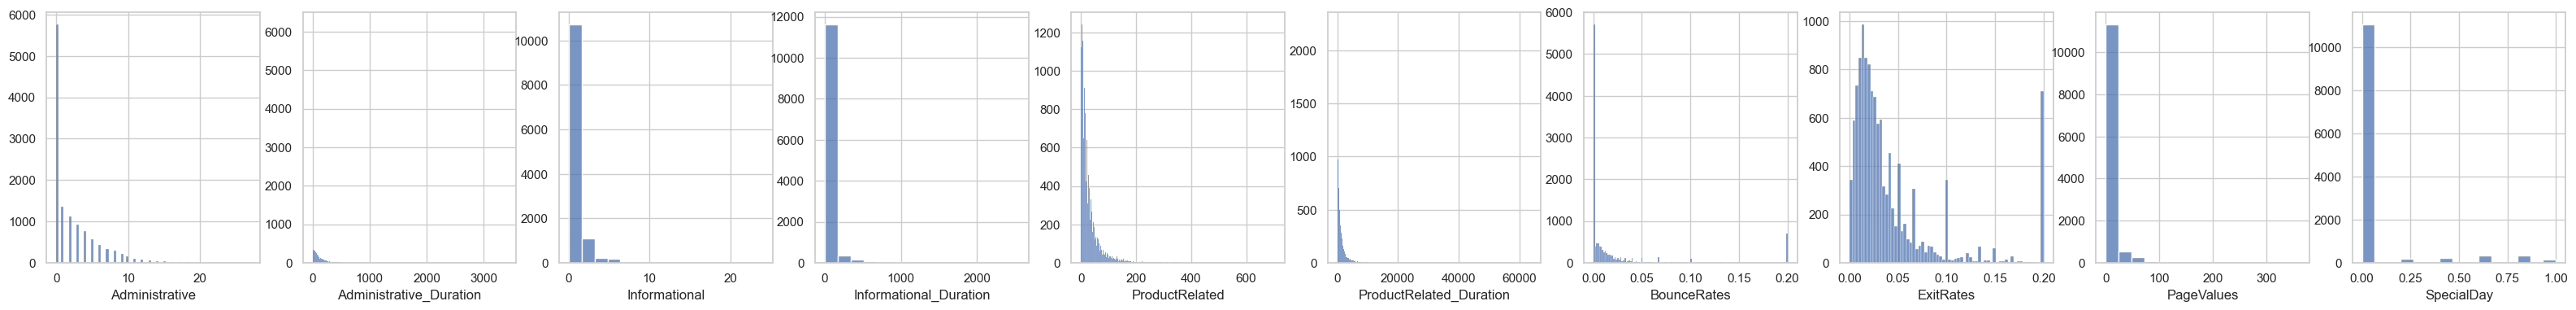

Administrative  Administrative_Duration  Informational  \
count    12330.000000             12330.000000   12330.000000   
mean         2.315166                80.818611       0.503569   
std          3.321784               176.779107       1.270156   
min          0.000000                 0.000000       0.000000   
25%          0.000000                 0.000000       0.000000   
50%          1.000000                 7.500000       0.000000   
75%          4.000000                93.256250       0.000000   
max         27.000000              3398.750000      24.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count            12330.000000    12330.000000             12330.000000   
mean                34.472398       31.731468              1194.746220   
std                140.749294       44.475503              1913.669288   
min                  0.000000        0.000000                 0.000000   
25%                  0.000000        7.000000               184.137500   
50%                  0.000000       18.000000               598.936905   
75%                  0.000000       38.000000              1464.157214   
max               2549.375000      705.000000             63973.522230   

        BounceRates     ExitRates    PageValues    SpecialDay  
count  12330.000000  12330.000000  12330.000000  12330.000000  
mean       0.022191      0.043073      5.889258      0.061427  
std        0.048488      0.048597     18.568437      0.198917  
min        0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.014286      0.000000      0.000000  
50%        0.003112      0.025156      0.000000      0.000000  
75%        0.016813      0.050000      0.000000      0.000000  
max        0.200000      0.200000    361.763742      1.000000

In [4]:
variable_numerical = ['Administrative', 'Administrative_Duration', 'Informational','Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues','SpecialDay']
hist(webdata_raw,variable_numerical)
webdata_raw[variable_numerical].describe()

### Categorical Variable

| Feature                    | Description                                                                                   |
|----------------------------|-----------------------------------------------------------------------------------------------|
| Month                      | Month of the year                                                                             |
| Operating System           | Type of operating system used to visit the website                                            |
| Browser                    | Type of browser used to visit the website                                                     |
| Region                     | Region of the visitor                                                                         |
| Traffic Type               | Type of traffic                                                                               |
| Visitor Type               | Whether the customer is a returning or new visitor                                            |
| Weekend                    | Boolean value indicating whether the date of the visit is a weekend                           |

The bar chart below shows the distribution on each category. In _'OperatingSystems'_, value [1,2,3,4,8] contribute most of the value compare to others; In _'Browser'_ value [1,2,3,4,5,6,8,10] contribute most of the value compare to others; In _'TrafficType'_ value [1,2,3,4,5,6,8,10,11,13,20] contribute most of the value compare to others.

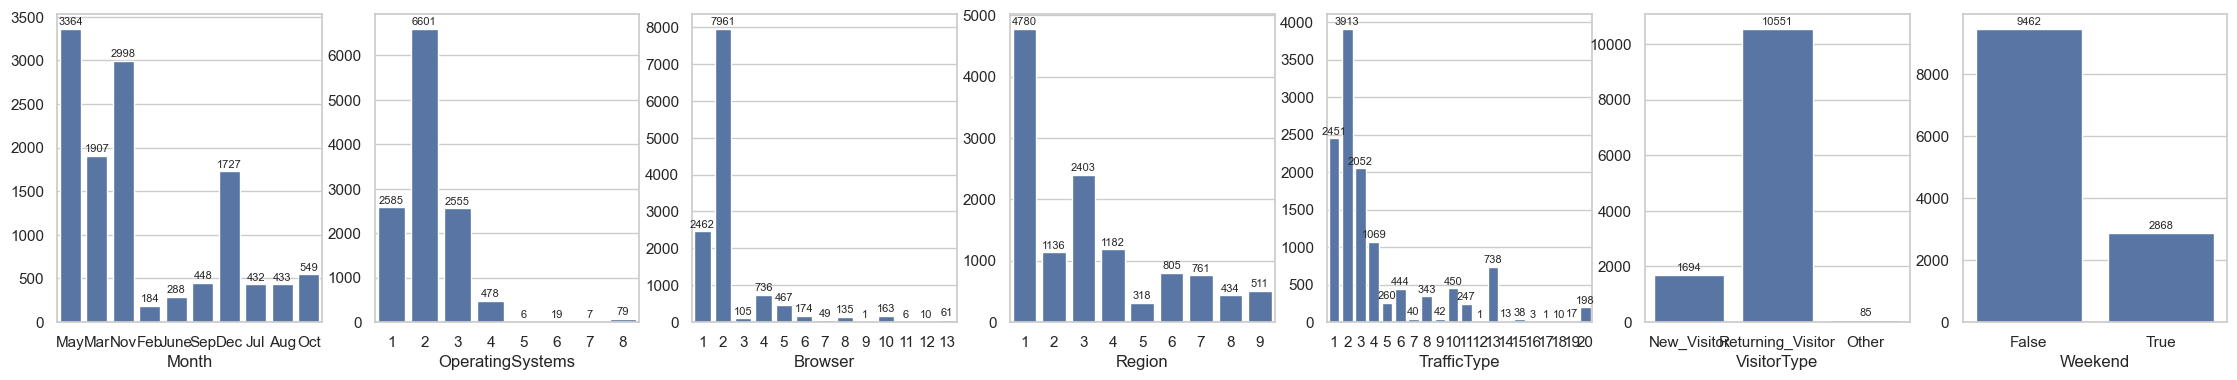

In [5]:
variable_categorical = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']
bar(webdata_raw,variable_categorical)


# 3 Pre-Clustering Data Preparation
This section will perform data cleaning, imputation and transformation.  

### 3.1 Null Value
There are no null value in the dataset.

In [6]:
webdata_raw.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
dtype: int64

### 3.2 _'SpecialDay'_
_'SpecialDay'_ is a numerical variable indicates the closeness of the site visiting time to a specific special day. The closer the value is to 1.0, the closer the time is to a special day. In this variable, the primary focus is not on the closeness of special day. Instead, the main emphasis lies on investigating whether special days have an impact on the clusters or prediction outcomes.  
Under this notion, we take the value [0.2,1.0] and combine them into 1.0, and the variable becomes a binary variable indicating whether the site visiting time is close to a specific special day. Now we have 0: 11079 and 1:1251 for _'SpecialDay'_.

| Feature                    | Data Type   | Description                                                                       |
|----------------------------|-------------|-----------------------------------------------------------------------------------|
| SpecialDay                 | Categorical | Indicating whether the site visiting time is close to a specific special day      |

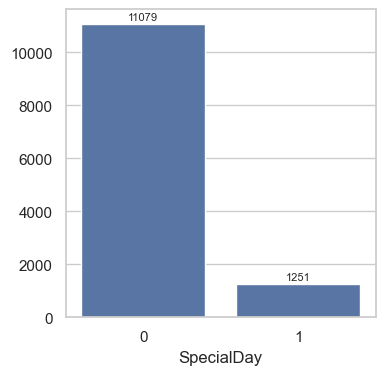

In [7]:
webdata_raw['SpecialDay'] = (webdata_raw['SpecialDay']>=.2).astype(int)
bar(webdata_raw,['SpecialDay'])
# Move 'SpecialDay' into categorical
variable_numerical = ['Administrative', 'Administrative_Duration', 'Informational','Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues']
variable_categorical = ['SpecialDay', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

### 3.3 Outliers
There are a significant amount of outliers in the numerical variables according to the histogram in __Part 2__.  In this section we will use Interquartile Range (IQR) Method to remove the outliers.  
However, variable _'BounceRates', 'ExitRates'_ has a large amount of value around right extreme and removing the value on the far right will result in losing significant data variance. Variable _'Informational','Informational_Duration','PageValues'_ has most value as 0 and will lose all data variance after removing the outliers. The outliers in these variables will be retained and included in the analysis.

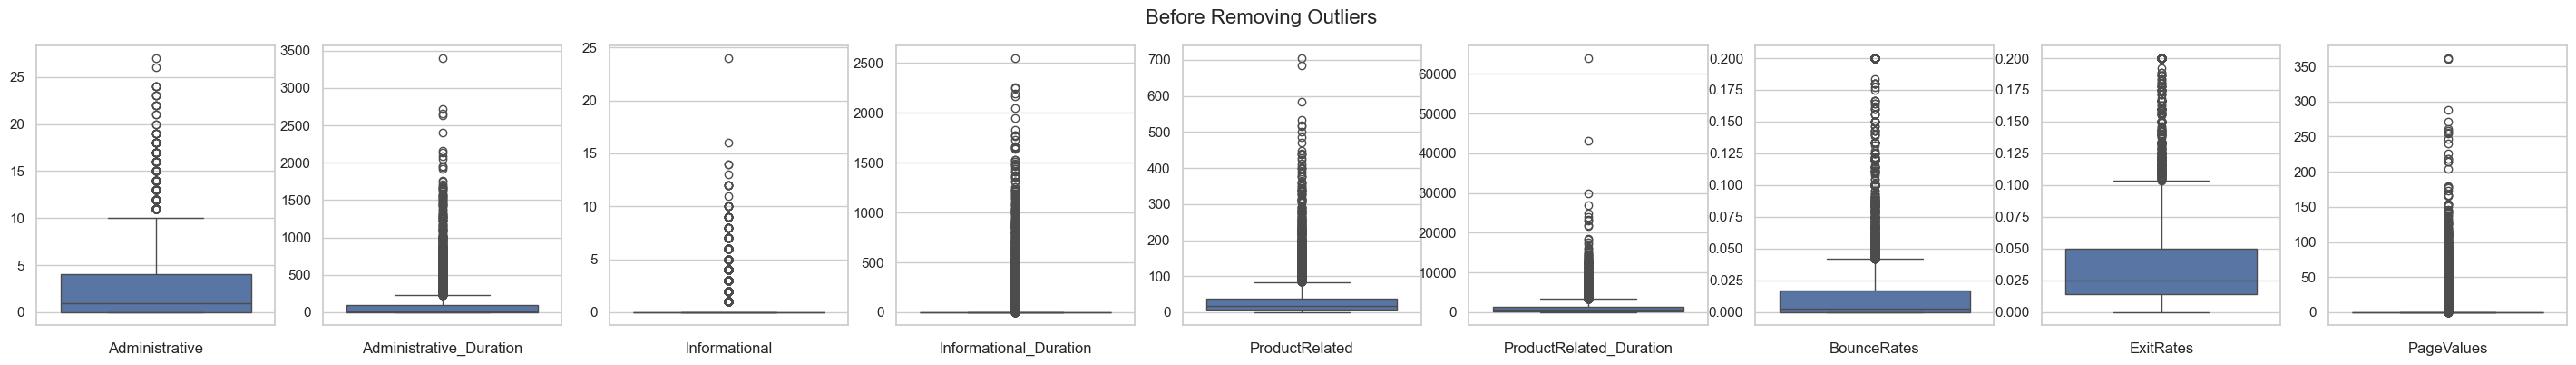

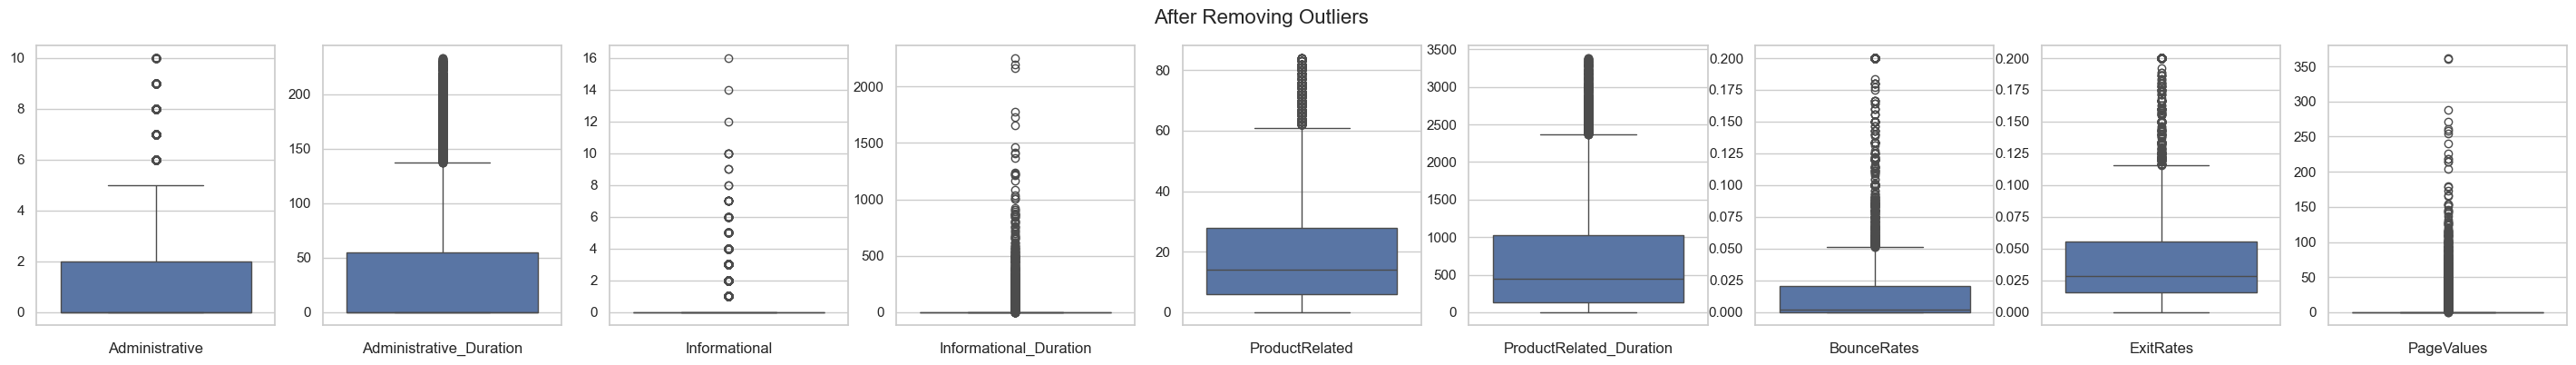

In [8]:
variable_remv_outlier = ['Administrative', 'Administrative_Duration', 'ProductRelated', 'ProductRelated_Duration']
box(webdata_raw,variable_numerical,"Before Removing Outliers")
def remove_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df >= lower_bound) & (df <= upper_bound)].dropna()

cleaned = remove_outliers_iqr(webdata_raw[variable_remv_outlier])
webdata_cleaned = (pd.concat([cleaned, webdata_raw.drop(columns=variable_remv_outlier)], axis=1)).dropna()
box(webdata_cleaned,variable_numerical,"After Removing Outliers")

### 3.4 Box-Cox Transformation
In order to solve the skewness in numerical data, this section performs a Box-Cox transformation. Some variables have 0 as value, add 1 to enable box-cox algorithm.

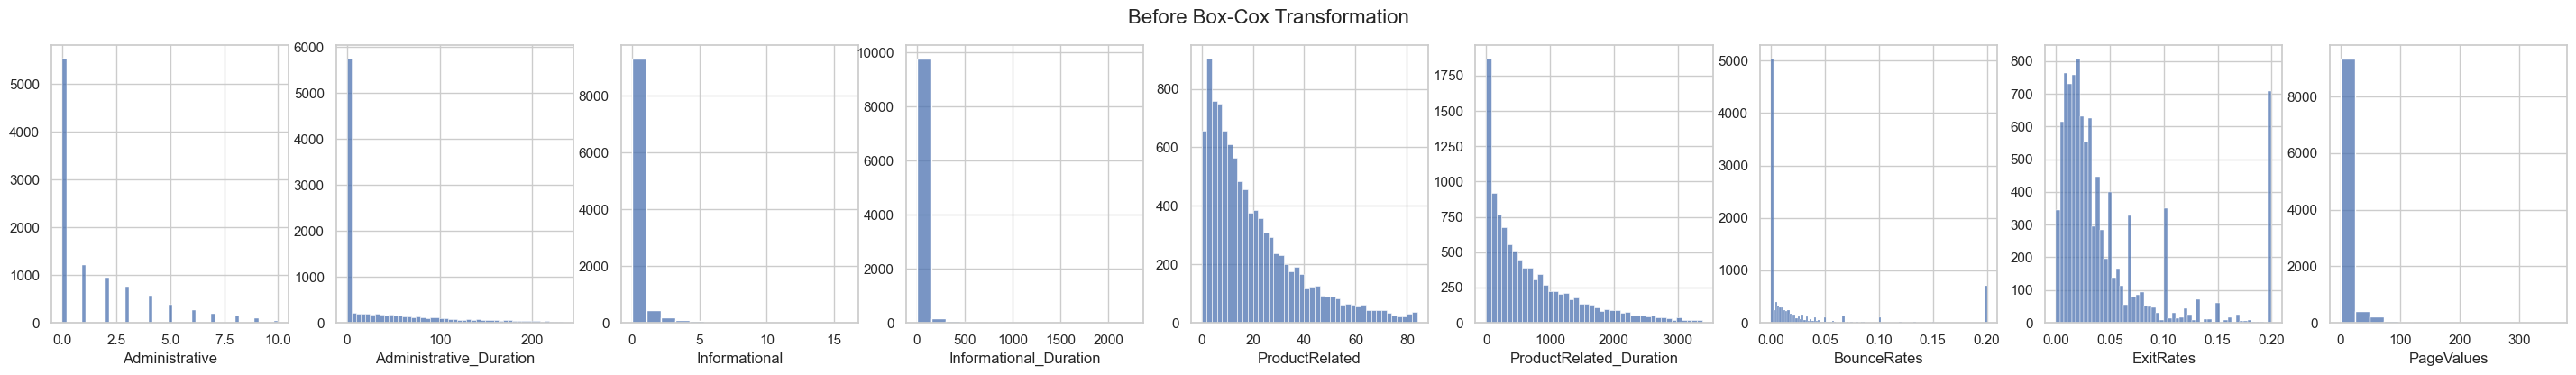

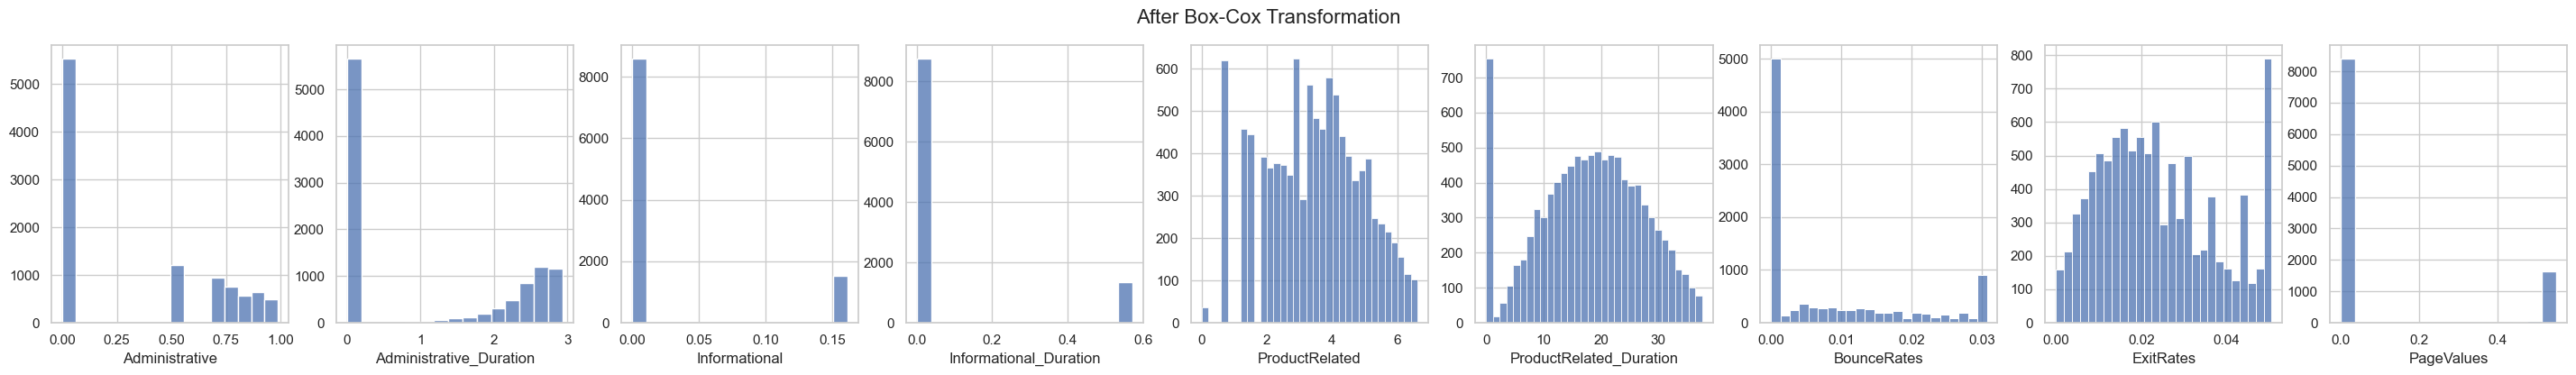

In [9]:
hist(webdata_cleaned,variable_numerical,"Before Box-Cox Transformation")
webdata_transformed=webdata_cleaned.copy()
for column in variable_numerical:
    transformed_data, _ = boxcox(webdata_cleaned[column] + 1) 
    webdata_transformed[column] = transformed_data
hist(webdata_transformed,variable_numerical,"After Box-Cox Transformation")

### 3.5 Standardization
Perform standardization on the numerical variables. Standardization is very crucial for clustering methods.

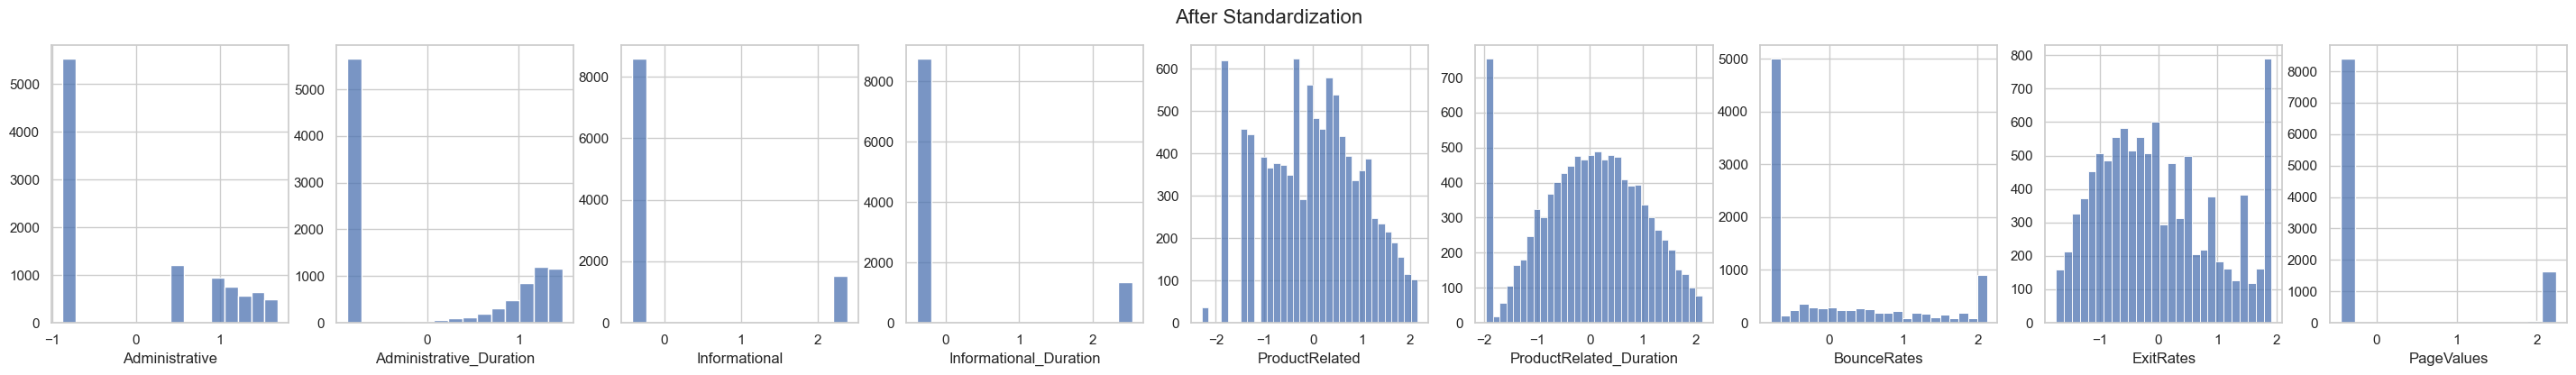

In [10]:
webdata_standardized = StandardScaler().fit_transform(webdata_transformed[variable_numerical])

webdata_standardized = pd.DataFrame(webdata_standardized, columns=variable_numerical)
webdata_standardized.shape
hist(webdata_standardized,variable_numerical,"After Standardization")

### 3.6 Dummy Variables
This section turn all the categorical variables into Dummy label.  

__'Month'__ has 10 different values, turn them into a sequential label starting from 1. And then use getdummies to one hot code the variable.

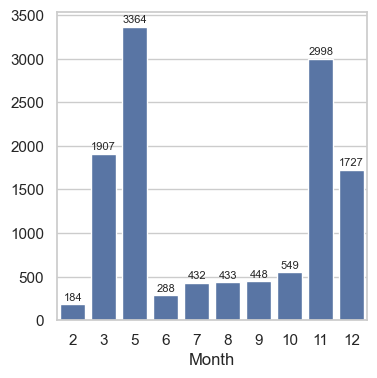

Month_2  Month_3  Month_5  Month_6  Month_7  Month_8  Month_9  \
0        False    False     True    False    False    False    False   
1        False     True    False    False    False    False    False   
2        False    False    False    False    False    False    False   
3        False    False    False    False    False    False    False   
4        False    False     True    False    False    False    False   
...        ...      ...      ...      ...      ...      ...      ...   
12325    False     True    False    False    False    False    False   
12326    False    False    False    False    False    False    False   
12327    False    False    False    False     True    False    False   
12328    False    False     True    False    False    False    False   
12329    False    False    False    False    False    False    False   

       Month_10  Month_11  Month_12  
0         False     False     False  
1         False     False     False  
2         False      True     False  
3         False      True     False  
4         False     False     False  
...         ...       ...       ...  
12325     False     False     False  
12326     False      True     False  
12327     False     False     False  
12328     False     False     False  
12329     False      True     False  

[12330 rows x 10 columns]

In [12]:
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'June': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

webdata_raw['Month'] = webdata_raw['Month'].map(month_mapping)
bar(webdata_raw,['Month'])
webdata_dummies = pd.get_dummies(webdata_raw, columns=['Month'])
webdata_dummies[['Month_2','Month_3','Month_5','Month_6','Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']]

__'OperatingSystems'__ has 8 different values but most values are [1,2,3,4]. So before truning them into dummy variables, drop the observations with too little observations.

In [13]:
top_4_OperatingSystems = [x for x in webdata_dummies['OperatingSystems'].value_counts().sort_values(ascending=False).head(4).index]
display(top_4_OperatingSystems)
webdata_dummies = pd.get_dummies(webdata_dummies[webdata_dummies['OperatingSystems'].isin(top_4_OperatingSystems)], columns=['OperatingSystems'])

[2, 1, 3, 4]

__'Browser'__ has 13 different values. Before truning them into dummy variables, drop the observations with too little observations.

In [14]:
top_8_Browser = [x for x in webdata_dummies['Browser'].value_counts().sort_values(ascending=False).head(8).index]
display(top_8_Browser)
webdata_dummies = pd.get_dummies(webdata_dummies[webdata_dummies['Browser'].isin(top_8_Browser)], columns=['Browser'])

[2, 1, 4, 5, 6, 10, 8, 3]

__'Region'__

In [15]:
webdata_dummies = pd.get_dummies(webdata_dummies, columns=['Region'])

__'TrafficType'__ has 20 different values. And there are many category have little rows. Before truning them into dummy variables, drop the observations with too little observations.

In [16]:
top_11_TrafficType = [x for x in webdata_dummies['TrafficType'].value_counts().sort_values(ascending=False).head(11).index]
display(top_11_TrafficType)
webdata_dummies = pd.get_dummies(webdata_dummies[webdata_dummies['TrafficType'].isin(top_11_TrafficType)], columns=['TrafficType'])

[2, 1, 3, 4, 13, 10, 6, 8, 5, 11, 20]

__'VisitorType'__ has three different types, _'New_Visitor'_ and _'Returning_Visitor'_ has most of the values. But variable  _'other'_ only have 85 values thus it can be dropped.

In [17]:
VisitorType = [x for x in webdata_dummies['VisitorType'].value_counts().sort_values(ascending=False).head(1).index]
display(VisitorType)
webdata_dummies = pd.get_dummies(webdata_dummies[webdata_dummies['VisitorType'].isin(VisitorType)], columns=['VisitorType'])


['Returning_Visitor']

### 3.7 Overview
Finally concat the standardized numerical variables with labeled categorical variables, save the final dataframe as _'webdata'_. The variable has 8482 observations after the preparation process and have 54 variables.

In [19]:
variable_categorical = [x for x in webdata_dummies.columns if x not in variable_numerical]
webdata_dummies = webdata_dummies[variable_categorical]
webdata_dummies = webdata_dummies.astype(int)

webdata = pd.concat([webdata_standardized, webdata_dummies], axis=1, join='inner')
display(webdata.shape)
webdata.head()

(8482, 54)

Administrative  Administrative_Duration  Informational  \
1       -0.875987                -0.869998      -0.422370   
3        1.345118                 1.328652      -0.422370   
4        0.468467                 1.161892       2.347916   
5        0.468467                -0.869998      -0.422370   
6        1.192484                 0.663207      -0.422370   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
1               -0.395842        0.010390                 0.751537   
3               -0.395842        0.144296                 0.342023   
4                2.520737        0.664484                 0.360572   
5               -0.395842        0.376874                 1.601889   
6               -0.395842       -0.621035                -0.933875   

   BounceRates  ExitRates  PageValues  SpecialDay  ...  TrafficType_3  \
1     0.292645   0.484103   -0.452545           0  ...              0   
3    -0.783077  -0.968196   -0.452545           0  ...              1   
4    -0.783077  -1.473551   -0.452545           0  ...              0   
5    -0.783077  -0.372041    2.212635           0  ...              1   
6    -0.783077  -0.549971   -0.452545           0  ...              0   

   TrafficType_4  TrafficType_5  TrafficType_6  TrafficType_8  TrafficType_10  \
1              0              0              0              0               0   
3              0              0              0              0               0   
4              1              0              0              0               0   
5              0              0              0              0               0   
6              0              0              0              0               0   

   TrafficType_11  TrafficType_13  TrafficType_20  \
1               0               0               0   
3               0               0               0   
4               0               0               0   
5               0               0               0   
6               0               0               0   

   VisitorType_Returning_Visitor  
1                              1  
3                              1  
4                              1  
5                              1  
6                              1  

[5 rows x 54 columns]

# 4 Cluster Modeling
This part contains the modeling and analysis of the clusters in the dataset using hierarchical clustering and K-means clustering.

### 4.1 Hierarchical clustering

The dendrogram below indicates the last two merge have a larger merging distance compared to the previous merging processes. The longer clustering distance in a dendrogram indicates a greater dissimilarity or distance between the clusters being merged. The dendrogram shows there are 3 clusters with a obvious dissimilarity, but two of the clusters have a closer similarity.  
Therefore, for this dataset, the algorithm can effectively distinguish three clusters with the clustering distance just below 170, or two clusters with the clustering distance around 200. 

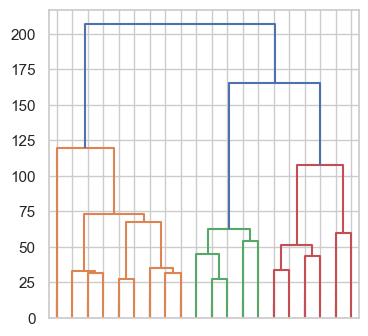

In [20]:
fig, ax = plt.subplots(figsize=(4, 4))
hierarchy.dendrogram(
    hierarchy.linkage(webdata, method="ward"),
    truncate_mode="lastp",
    p=20,
    show_leaf_counts=False,
    show_contracted=True,
)
plt.show()

### 4.2 K-means clustering
This section will implement a K-means clustering algorithm.

- __Elbow Plot__  
Start by using a range of values for K to create an elbow plot. Record the inertias and plot in a line chart. The elbow point is __k=4__ or __k=5__, indicating that the optimal number for clusters is 4 or 5.  

- __Silhouette Plot__  
The silhouette plot indicates that k=2 or k=3 is a very good choice, and the silhouette score decline as k increases. So __k=2__ or __k=3__ is the best choice.  

- __Calinski-Harabasz Plot__  
Higher Calinski-Harabasz scores implies that the clusters are dense and well-separated from each other. The best value for k is __k=2__.

- __Davies-Bouldin Plot__  
Lower Davies-Bouldin scores indicate better clustering. The best value for k is __k=5__.

array([[<Axes: xlabel='k'>, <Axes: xlabel='k'>],
       [<Axes: xlabel='k'>, <Axes: xlabel='k'>]], dtype=object)

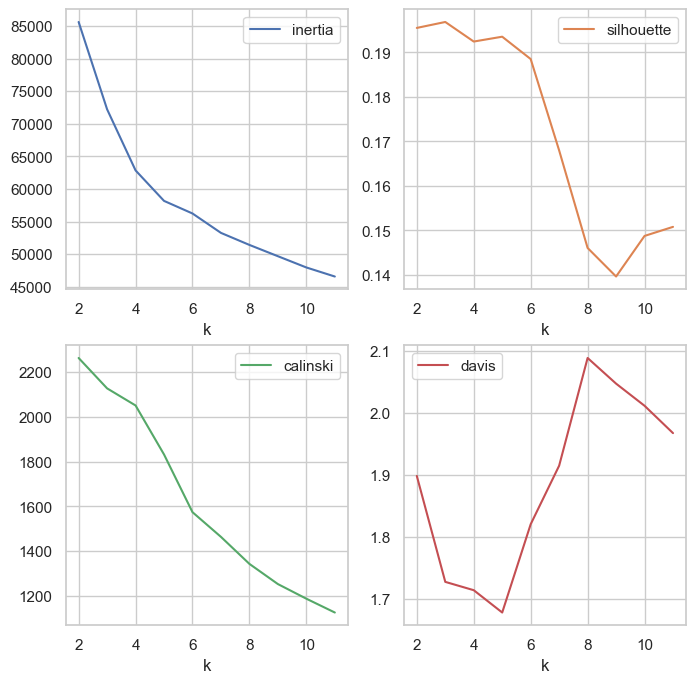

In [21]:
inertias, sils, chs, dbs = [], [], [], []
sizes = range(2, 12)
for k in sizes:
    k2 = KMeans(random_state=53, n_clusters=k, n_init=10)
    k2.fit(webdata)
    inertias.append(k2.inertia_)
    sils.append(metrics.silhouette_score(webdata, k2.labels_))
    chs.append(metrics.calinski_harabasz_score(webdata, k2.labels_))
    dbs.append(metrics.davies_bouldin_score(webdata, k2.labels_))
fig, ax = plt.subplots(figsize=(8, 8))

pd.DataFrame(
{
    "inertia": inertias,
    "silhouette": sils,
    "calinski": chs,
    "davis": dbs,
    "k": sizes,
    }
).set_index("k").plot(ax=ax, subplots=True, layout=(2, 2))


### 4.3 Comparison
From the algorithms above, the suggested k value falls mostly on __k=2__, followed by __k=3__ and __k=5__.
|  Algorithm            | Hierarchical Clustering | Elbow Plot | Silhouette Score | Calinski-Harabasz Score | Davies-Bouldin Score |
|-----------------------|-------------------------|------------|------------------|-------------------------|----------------------|
| suggested k value     | 2,3 | 4,5 | 2,3 | 2 | 5 |  

# 5 Post Clustering EDA
Apply a K-means clustering algorithm to the data set using a value of __K=2__. After implementing the K-means clustering algorithm there will be two groupings of data.

In [22]:
kmeans = KMeans(n_clusters=2, random_state=53)
kmeans.fit(webdata)
cluster_labels = kmeans.labels_

### 5.1 Means Value Analysis
This section calculates the mean of each numerical variables in both clusters. The mean of two clusters indicate that the groupings are noticeably different from one another.

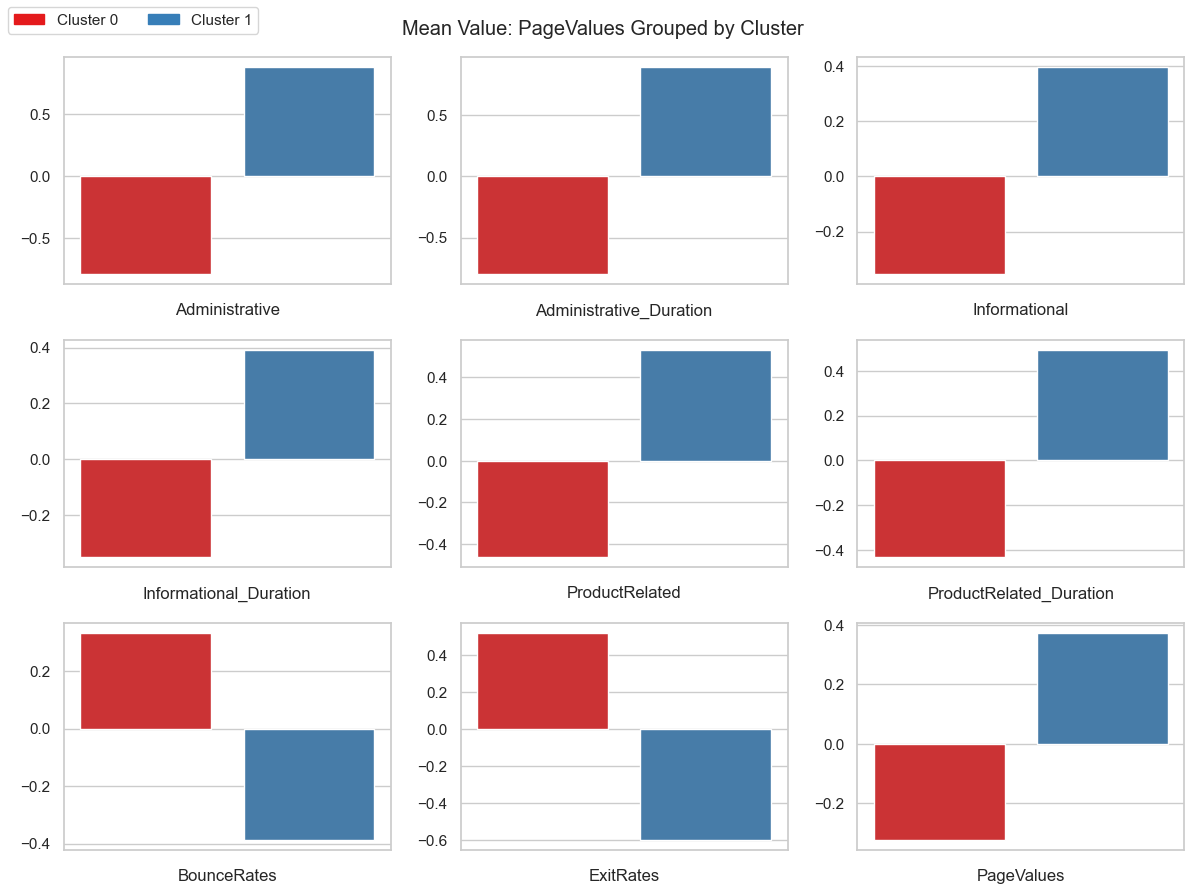

In [23]:
webdata_cluster = webdata[variable_numerical].copy()
webdata_cluster['Cluster'] = cluster_labels
cluster_means = webdata_cluster.groupby('Cluster').mean()
bar_sum(cluster_means, "Mean Value")

### 5.2 PCA
Perform a PCA on all the numerical variables. The scree plot below shows that the PC1 and PC2 contribute to 62% of the explained data variance. PC1-PC5 contribute to 95% of the explained data variance. The further analysis can be based on PC1-PC5 and mainly the distribution of PC1 and PC2.

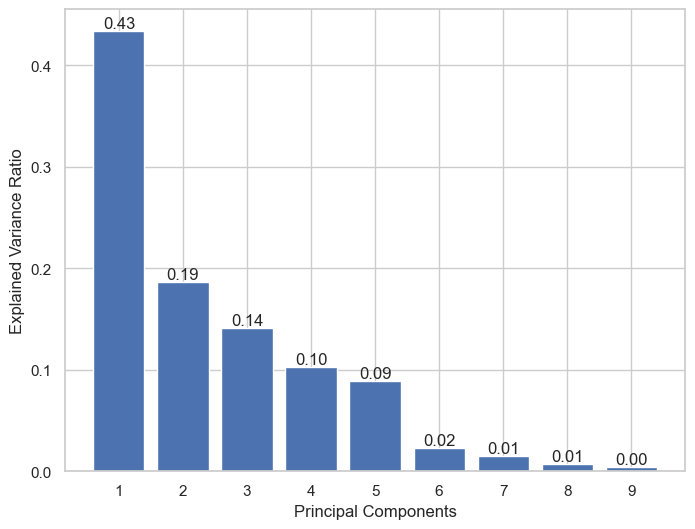

In [24]:
pca = PCA()
pca.fit(webdata[variable_numerical])

explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
bars = plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)

plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(True)

# Add numbers on top of each bar
for bar, ratio in zip(bars, explained_variance_ratio):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{ratio:.2f}', 
             ha='center', va='bottom')

plt.show()

Make a Principal Components 1 to 5 comparison to each other and plot the clusters as the hue. The plot in PC1-2 and PC1-3 shows a clear pattern that the clusters are devided according to the distribution indicated by Principal Components. However the cluster is not perfect. 

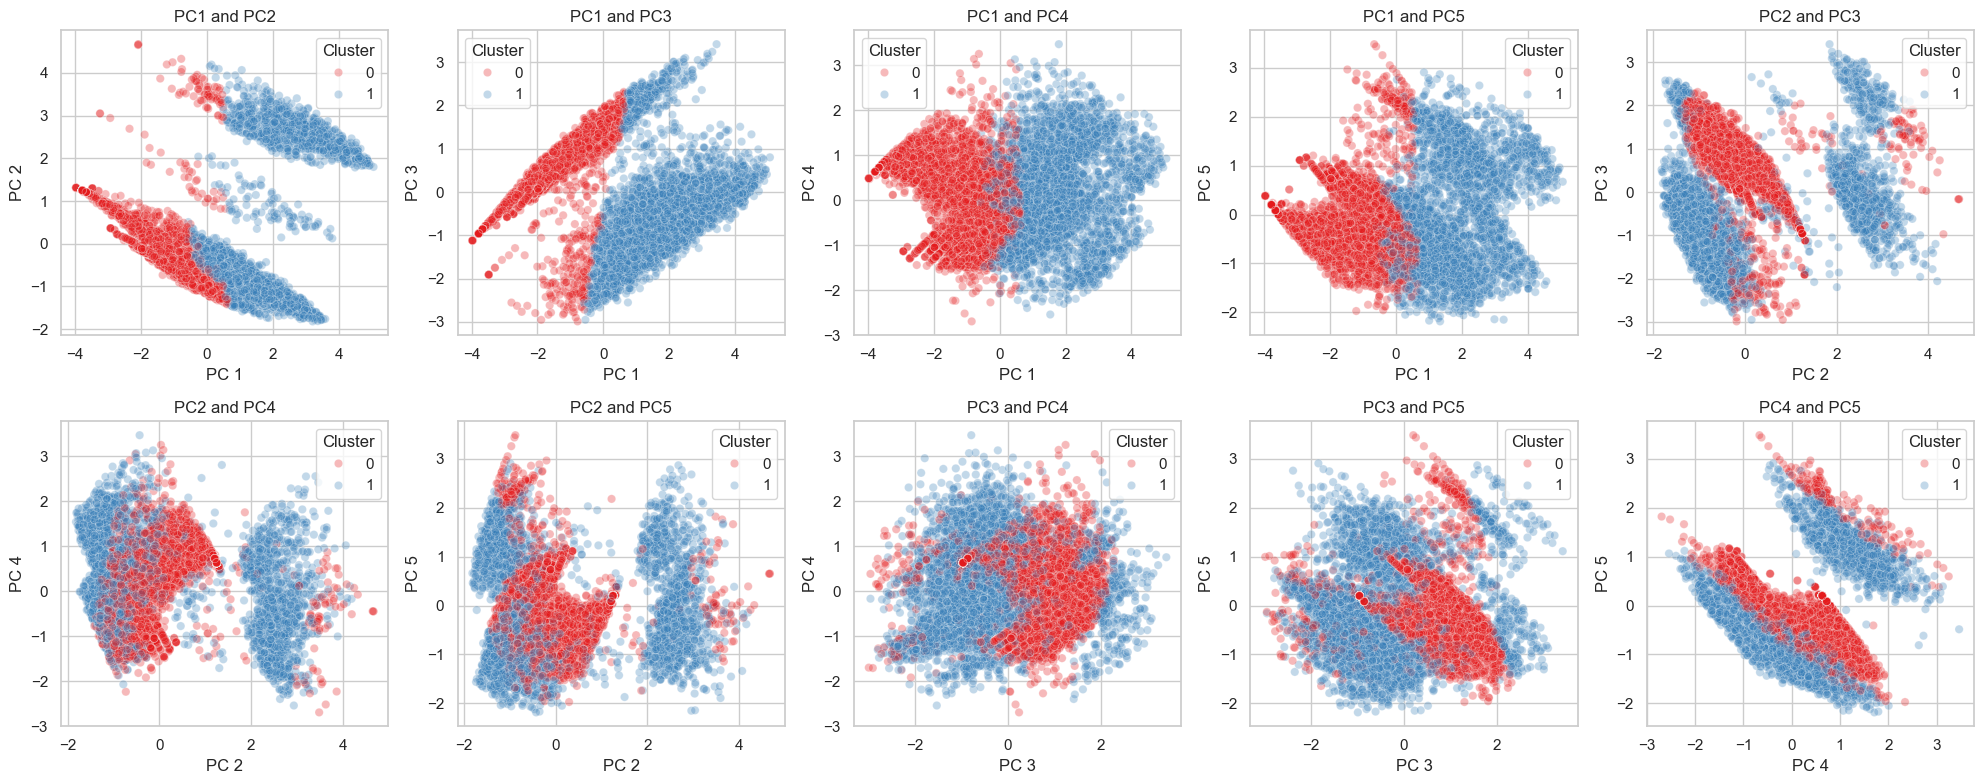

In [25]:
transformed_data = pca.transform(webdata[variable_numerical])
transformed_data = pd.DataFrame(transformed_data[:, :10], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'])
transformed_data['Cluster'] = cluster_labels

plt.figure(figsize=(20, 8)) 
pc_pairs = list(itertools.combinations(range(1, 6), 2))
for idx, (pc1, pc2) in enumerate(pc_pairs, start=1): 
    plt.subplot(2, 5, idx)  
    sns.scatterplot(x=f'PC{pc1}', y=f'PC{pc2}', hue='Cluster', data=transformed_data, palette='Set1', alpha=0.3)
    plt.xlabel(f'PC {pc1}')
    plt.ylabel(f'PC {pc2}')
    plt.title(f'PC{pc1} and PC{pc2}')
    plt.grid(True)

plt.tight_layout() 
plt.show()



# 6 Clustering Output vs Actual Labels

Add a new column to your Pandas dataframe with the name Revenue. Within this new column, insert 
the grouping assignments identified by your K-means clustering for each observation within the data 
set.

In [26]:
webdata['Revenue'] = cluster_labels

Read the Project2_Data_Labels.csv file from Github repository and add its content to another new column name of _'V_Revenue'_. 
This new column contains the actual classification labels for the observations contained within the data set and indicates whether or not a web site visitor executed a purchase before leaving the web site.  
Compare the values of _'V_Revenue'_ with the clustering result _'Revenue'_.  The V_Revenue has a slightly smaller standard deviation and a smaller mean value.



In [27]:
Actual_label = pd.read_csv("https://raw.githubusercontent.com/jc000222/Data_Science_DAV6150/main/M9/Project2_Data_Labels.csv")
Actual_label = Actual_label.rename(columns={'Revenue': 'V_Revenue'})
Actual_label = Actual_label.astype(int)
webdata_final = pd.concat([webdata, Actual_label], axis=1, join='inner')

display(webdata_final[['V_Revenue','Revenue']].describe())

# Calculate additional evaluation metrics
accuracy = accuracy_score(webdata_final['V_Revenue'], webdata_final['Revenue'])
precision = precision_score(webdata_final['V_Revenue'], webdata_final['Revenue'])
recall = recall_score(webdata_final['V_Revenue'], webdata_final['Revenue'])
f1 = f1_score(webdata_final['V_Revenue'], webdata_final['Revenue'])
conf_matrix = confusion_matrix(webdata_final['V_Revenue'], webdata_final['Revenue'])
auc_score = roc_auc_score(webdata_final['V_Revenue'], webdata_final['Revenue'])

# Print the evaluation metrics
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC Score:", auc_score)  # Added AUC score here
print("Confusion Matrix:\n", conf_matrix)

V_Revenue      Revenue
count  8482.000000  8482.000000
mean      0.136171     0.468993
std       0.342990     0.499067
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.000000     0.000000
75%       0.000000     1.000000
max       1.000000     1.000000

Test Accuracy: 0.5233435510492809
Precision: 0.13700351935646055
Recall: 0.47186147186147187
F1 Score: 0.2123514513929476
AUC Score: 0.5016602295843459
Confusion Matrix:
 [[3894 3433]
 [ 610  545]]


# 7 SVM Modeling

Separate the dataframe into model training and testing subsets. The target variable is biased so performing __SMOTE__ is necessary.

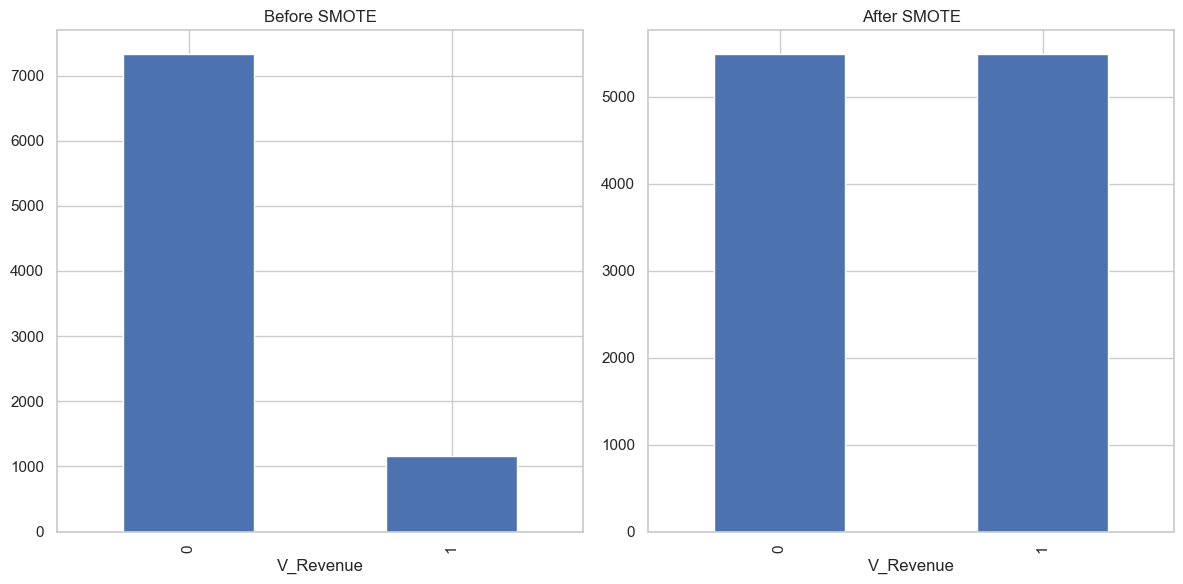

In [28]:
webdata_SVM = webdata_final.copy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Subplot 1
webdata_SVM['V_Revenue'].value_counts().plot(kind='bar')
plt.title('Before SMOTE')

y = webdata_SVM['V_Revenue']
X = webdata_SVM.drop(['Revenue','V_Revenue'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)


plt.subplot(1, 2, 2) 
y_train.value_counts().plot(kind='bar')
plt.title('After SMOTE')

plt.tight_layout()  
plt.show()


In order to improve the model accuracy and reduce overfitting，use __RFE__ method to do the feature selection and select the top 20 features out of 54 features.

In [29]:
logreg = LogisticRegression(max_iter=1000) 

rfe = RFE(estimator=logreg, n_features_to_select=20) 
rfe = rfe.fit(X_train, y_train.values.ravel()) 

# Gets the column name of the feature selected by RFE
selected_features = X_train.columns[rfe.support_]

X_train_1 = X_train
y_train_1 = y_train
X_train_2 = X_train[selected_features]
y_train_2 = y_train

# Output the results of RFE.
print("Selected features by RFE:")
print(rfe.support_)
print("Feature ranking (1 indicates selected):")
print(rfe.ranking_)
print("Selected features by RFE (ranking 1):")
print(selected_features)

Selected features by RFE:
[False False False False False False False False False False False False
 False False False False False False False False False  True  True  True
  True False False False False False False False False  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
 False  True False  True False False]
Feature ranking (1 indicates selected):
[26 27 28 35 32 30 29 31 33 24 25  6  9 10  7 12 11 13 14 15  8  1  1  1
  1 23 21 17 18 19 16 22 20  1  1  1  1  1  1  1  1  1  1  4  1  1  1  1
  5  1  3  1  2 34]
Selected features by RFE (ranking 1):
Index(['OperatingSystems_1', 'OperatingSystems_2', 'OperatingSystems_3',
       'OperatingSystems_4', 'Region_1', 'Region_2', 'Region_3', 'Region_4',
       'Region_5', 'Region_6', 'Region_7', 'Region_8', 'Region_9',
       'TrafficType_1', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5',
       'TrafficType_6', 'TrafficType_10', 'TrafficType_13'],
      dtype='object')


### SVM Classifier 1
Use all the explanatory variables for the first model and evaluate the performance of your models via cross validation using the training data set. 

In [35]:
SVM_classifier_1 = SVC()
SVM_classifier_1.fit(X_train_1, y_train_1)

cv_scores = cross_val_score(SVM_classifier_1, X_train_1, y_train_1, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Scores:", cv_scores.mean())

Cross-Validation Scores: [0.61930783 0.96357013 0.96857923 0.96812386 0.96584699]
Mean CV Scores: 0.8970856102003644


### SVM Classifier 2
Use all the explanatory variables for the first model and evaluate the performance of your models via cross validation using the training data set. 

In [36]:
SVM_classifier_2 = SVC()
SVM_classifier_2.fit(X_train_2, y_train_2)

cv_scores = cross_val_score(SVM_classifier_2, X_train_2, y_train_2, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Scores:", cv_scores.mean())

Cross-Validation Scores: [0.63661202 0.84608379 0.8510929  0.86111111 0.8579235 ]
Mean CV Scores: 0.8105646630236795


# 8 Select Models

Examine the metrics of models on the test dataset.

In [37]:
y_pred = SVM_classifier_1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Test Accuracy: 0.8477133427628477
Precision: 0.3274336283185841
Recall: 0.13028169014084506
F1 Score: 0.18639798488664988
Confusion Matrix:
 [[1761   76]
 [ 247   37]]


In [38]:
y_pred = SVM_classifier_2.predict(X_test[selected_features])

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Test Accuracy: 0.7571900047147572
Precision: 0.22695035460992907
Recall: 0.3380281690140845
F1 Score: 0.27157001414427157
Confusion Matrix:
 [[1510  327]
 [ 188   96]]


| Metric      | SVM Classifier 1 | SVM Classifier 2 |
|-------------|------------------|------------------|
| Test Accuracy | 0.845 | 0.779 |
| Precision   | 0.320            | 0.247            |
| Recall      | 0.137            | 0.317            |
| F1 Score    | 0.192            | 0.277            |

- Test Accuracy: SVM Classifier 1 achieved higher accuracy (0.845) compared to SVM Classifier 2 (0.779).  
- Precision: SVM Classifier 1 has a precision of 0.320, indicating that it correctly identifies 32% of the positive cases. SVM Classifier 2 has a lower precision of 0.247.  
- Recall: SVM Classifier 2 has a higher recall (0.317) compared to SVM Classifier 1 (0.137). This suggests that SVM Classifier 2 captures a larger proportion of actual positive cases.  
- F1 Score: SVM Classifier 2 has a higher F1 score (0.277) than SVM Classifier 1 (0.192), indicating a better balance between precision and recall.  

In summary, while SVM Classifier 1 has a higher overall accuracy, SVM Classifier 2 performs better in terms of recall and F1 score, suggesting it may be better at correctly identifying positive cases. While neither model achieves exceptionally high performance, __SVM classifier 2__ appears to offer a better balance between precision, recall, and overall accuracy, making it a reasonable choice for predicting revenue.

# 9 Clustering + SVM Output vs Actual Labels

In [39]:
Result = SVM_classifier_2.predict(X[selected_features])

### 9.1 Means Value Analysis
This section calculates the mean of each numerical variables in both clusters. The mean of two clusters indicate that the groupings are noticeably different from one another.

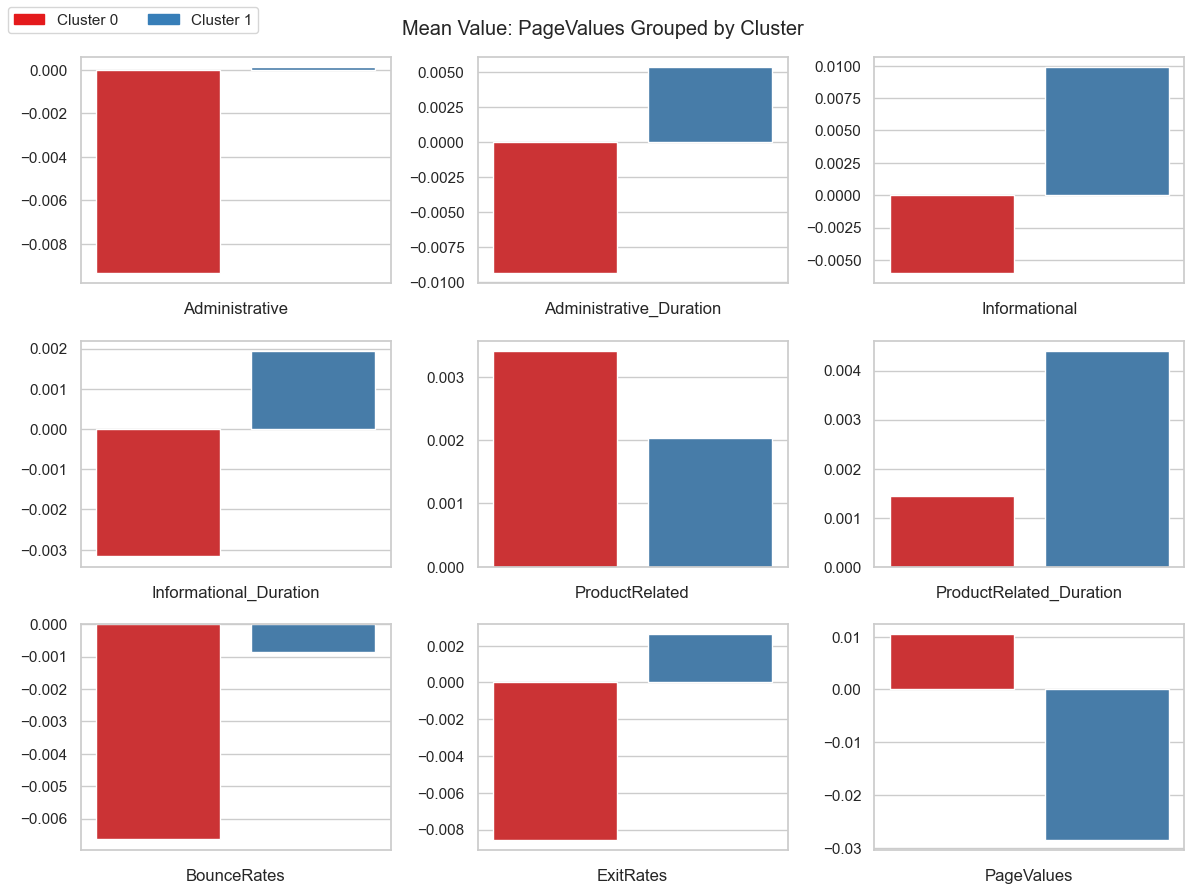

In [40]:
webdata_cluster = webdata[variable_numerical].copy()
webdata_cluster['Cluster'] = Result
cluster_means = webdata_cluster.groupby('Cluster').mean()
bar_sum(cluster_means, "Mean Value")

### 9.2 PCA
Perform a PCA on all the numerical variables. Make a Principal Components 1 to 5 comparison to each other and plot the clusters as the hue. The plot shows no pattern that the clusters are devided according to the distribution indicated by Principal Components.

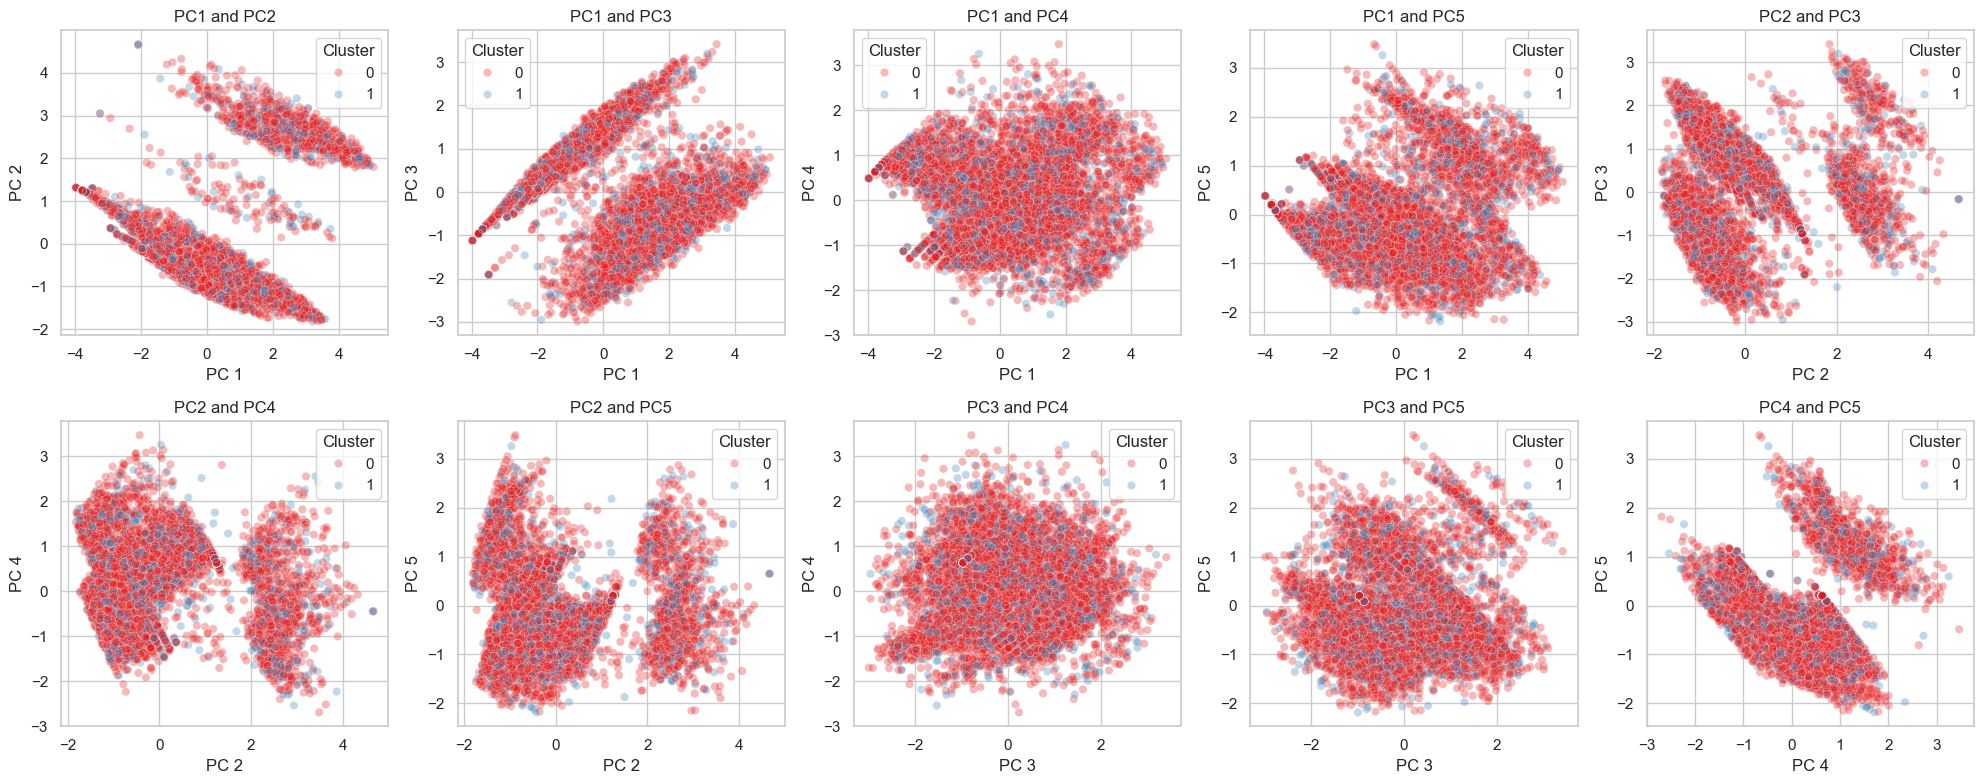

In [43]:
pca = PCA()
pca.fit(webdata[variable_numerical])

transformed_data = pca.transform(webdata[variable_numerical])
transformed_data = pd.DataFrame(transformed_data[:, :10], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'])
transformed_data['Cluster'] = Result

plt.figure(figsize=(20, 8)) 
pc_pairs = list(itertools.combinations(range(1, 6), 2))
for idx, (pc1, pc2) in enumerate(pc_pairs, start=1): 
    plt.subplot(2, 5, idx)  
    sns.scatterplot(x=f'PC{pc1}', y=f'PC{pc2}', hue='Cluster', data=transformed_data, palette='Set1', alpha=0.3)
    plt.xlabel(f'PC {pc1}')
    plt.ylabel(f'PC {pc2}')
    plt.title(f'PC{pc1} and PC{pc2}')
    plt.grid(True)

plt.tight_layout() 
plt.show()



### 9.3 Comparison

SVM

In [42]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Test Accuracy: 0.7571900047147572
Precision: 0.22695035460992907
Recall: 0.3380281690140845
F1 Score: 0.27157001414427157
Confusion Matrix:
 [[1510  327]
 [ 188   96]]


K-means

In [44]:
accuracy = accuracy_score(webdata_final['V_Revenue'], webdata_final['Revenue'])
precision = precision_score(webdata_final['V_Revenue'], webdata_final['Revenue'])
recall = recall_score(webdata_final['V_Revenue'], webdata_final['Revenue'])
f1 = f1_score(webdata_final['V_Revenue'], webdata_final['Revenue'])
conf_matrix = confusion_matrix(webdata_final['V_Revenue'], webdata_final['Revenue'])
auc_score = roc_auc_score(webdata_final['V_Revenue'], webdata_final['Revenue'])

# Print the evaluation metrics
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC Score:", auc_score)  # Added AUC score here
print("Confusion Matrix:\n", conf_matrix)

Test Accuracy: 0.5233435510492809
Precision: 0.13700351935646055
Recall: 0.47186147186147187
F1 Score: 0.2123514513929476
AUC Score: 0.5016602295843459
Confusion Matrix:
 [[3894 3433]
 [ 610  545]]


## 10 Conclusions
In this project, the aim was to understand the underlying patterns in the dataset and predict whether website visitors made a purchase based on internet data. Exploratory data analysis (EDA) was performed to assess the integrity and usability of the data, revealing imbalanced classes and necessitating data preparation steps. Following EDA, hierarchical and K-means clustering techniques were employed to identify meaningful groupings in the data. The analysis suggested that the dataset could be effectively clustered into two groups.  

After clustering, post-clustering EDA was conducted to explore the characteristics of the generated clusters and compare them to the actual revenue labels. Differences between the clusters were observed, but it was noted that the clustering algorithm's output did not perfectly align with the actual revenue labels.  

For SVM modeling, different models and feature selection methods were experimented with. Although SVM classifier 2 performed better than the other model, the overall performance was not as high as expected.

In conclusion, while the clustering and SVM modeling provided insights into the data, the overall performance was not as high as expected.

# Reference
- https://scikit-learn.org/stable/modules/model_evaluation.html
- https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset